# Case Study 1: Account Handle Sharing

On Twitter and some other social media platforms, although each user account has an immutable ID, many relationships are based on an account handle (called screen_name on Twitter) that is changeable and in general reusable. An exception is that handles of suspended accounts are not reusable on Twitter. Users may have legitimate reasons for changing handles. However, the possibility of changing and reusing handles exposes users to abuse such as username squatting and impersonation (Mariconti et al. 2017). In a recent example, multiple Twitter handles associated with different personas were used by the same Twitter account to spread the name of the Ukraine whistleblower in the US presidential impeachment case. 

For a concrete example of how handle changes can be exploited, consider the following chronological events: 
1. user_1(named @super_cat)follows user @kittie) who posts pictures of felines. 
2. user_2(named 3 (named @super_dog) post pictures of canines. 
3. user_1 tweets mentioning user_2: ”I love @kittie”. A mention on Twitter creates a link to the mentioned account profile. Therefore, at time step 3, user_1’s tweet is linked to user_2’s profile page. 
4. user_2 renames its handle to @tiger. 
5. user_3 renames its handle to @kittie, reusing user_2’s handle. 

Even though user_1’s social network is unaltered regardless of the name change (user_1 still follows user_2), name changes are not reflected in previous posts, so anyone who clicks on the link at step 3 will be redirected to user_3’s profile instead of to user_2 as originally intended by user_1. This type of user squatting, in coordination with multiple accounts, can be used to promote entities, run “follow-back” campaigns, infiltrate communities, or even promote polarization (Mariconti et al. 2017). Since social media posts are often indexed by search engines, these manipulations can be used to promote content beyond social media boundaries. 

To detect this kind of coordination on Twitter, we applied our approach using identity traces, namely Twitter handles. We started from a log of requests to Botometer.org, a social bot detection service of the Indiana University Observatory on Social Media (Yang et al. 2019). Each log record consists of a timestamp, the Twitter user id and handle, and the bot score. We focus on users with at least ten entries (queries) such that multiple handle changes could be observed. This yielded 54 million records with 1.9 million handles. For further details see Table 1.

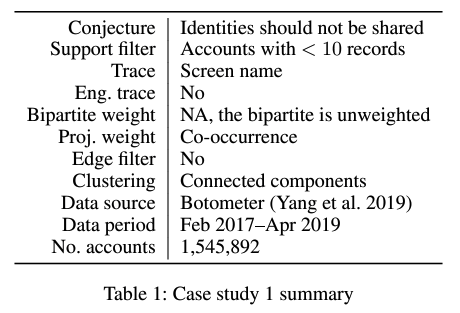

# Coordination Detection 
We create a bipartite network of suspicious handles and accounts. We consider a handle suspicious if it is shared by at least two accounts, and an account suspicious when it has taken at least one suspicious handle. Therefore no edges are filtered. One could be more restrictive, for example by considering an account suspicious if it has taken more than one suspicious handle. To detect the suspicious clusters we project the network, connecting accounts based on the number of times they shared a handle. This is equivalent to using co-occurrence, the simplest similarity measure. Each connected component in the resulting network identifies a cluster of coordinated accounts as well as the set of handles they shared. Table 1 summarizes the method decisions.

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import random

## Load Tweet File
We start by loading a file with raw tweets. In our example, the file is a json.gz and its structure is:
```
BEGIN_FILE
{tweet1_json}
{tweet2_json}
... 
{tweetN_json}
END_OF_FILE
```

In [2]:
raw_tweet_file = "tweets.json"

In [3]:
df = pd.read_json(raw_tweet_file, lines=True)
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11 non-null     int64 
 1   user    11 non-null     object
 2   text    11 non-null     object
dtypes: int64(1), object(2)
memory usage: 392.0+ bytes


,id,user,text
0,1,"{'id_str': '1111111', 'screen_name': 'super_cat'}",I love @kittie
1,2,"{'id_str': '222222', 'screen_name': 'kittie'}",bla bla bla


### For each tweet, extract the user_id and screen_name.

In [4]:
df = df.user.apply(pd.Series)[[
        "id_str",
        "screen_name"
]]
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_str       11 non-null     object
 1   screen_name  11 non-null     object
dtypes: object(2)
memory usage: 304.0+ bytes


,id_str,screen_name
0,1111111,super_cat
1,222222,kittie
2,3333333,super_dog


### Organise the dataframe per screen_name, identifying the number of unique users and their IDs.

In [5]:
circular_user = df.groupby("screen_name").agg(
    {"id_str":["nunique","unique"]}
)
circular_user.columns = ["nunique_usr","users"]
circular_user.info()
circular_user.head()
circular_user.sort_values("nunique_usr",ascending=False).head()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, kittie to user5
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   nunique_usr  6 non-null      int64 
 1   users        6 non-null      object
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes


,nunique_usr,users
screen_name,,
tiger,3,"[222222, 5555555, 6666666]"
kittie,2,"[222222, 3333333]"
super_dog,2,"[3333333, 222222]"
user5,2,"[4444445, 7777777]"
super_cat,1,[1111111]


### Create the edge list of users who share screen_names.

In [6]:
user_proj = pd.DataFrame(
    np.concatenate(
        circular_user[circular_user.nunique_usr>1].users.apply(combinations,r=2).apply(list)
    ),
    columns=["source","target"]
).groupby(["source","target"]).size().rename("weight").reset_index()

In [7]:
user_proj.info()
user_proj.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  6 non-null      object
 1   target  6 non-null      object
 2   weight  6 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 272.0+ bytes


,source,target,weight
0,222222,3333333,1
1,222222,5555555,1
2,222222,6666666,1
3,3333333,222222,1
4,4444445,7777777,1


### Create the network of suspicious users who shared screen_names

In [8]:
suspicious_net = nx.from_pandas_edgelist(user_proj,edge_attr="weight")

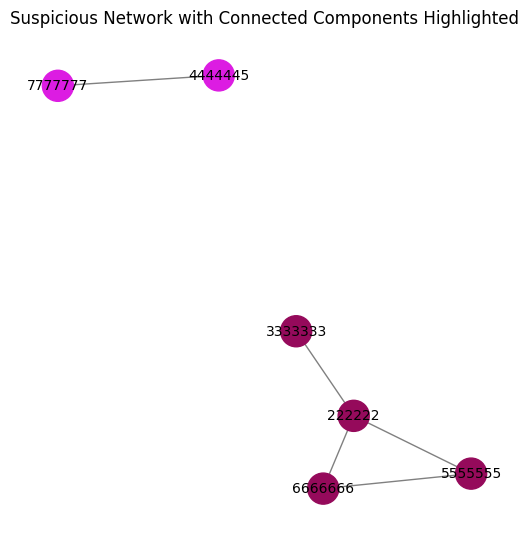

In [9]:
# Identify connected components
components = list(nx.connected_components(suspicious_net))  # Use for undirected graphs

# Assign a unique color to each component
color_map = {}
colors = [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in range(len(components))]
for i, component in enumerate(components):
    for node in component:
        color_map[node] = colors[i]

# Extract node colors
node_colors = [color_map[node] for node in suspicious_net.nodes]

# Plot the graph
pos = nx.spring_layout(suspicious_net)  # Layout for nodes
plt.figure(figsize=(5, 5))
nx.draw(suspicious_net, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=500, font_size=10)

plt.title("Suspicious Network with Connected Components Highlighted")
plt.show()